In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd
import tensorflow as tf# data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [37]:
p = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(p[0], 'GPU')

In [7]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.resnet152V2 import ResNet152V2
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [8]:
image_size = [224,224]
train = "/kaggle/input/diseasecotton/data/train"
valid = "/kaggle/input/diseasecotton/data/val"



In [9]:
# import os
# comp = [train,valid]
# for key in comp:
#     print(os.path.join(key))

In [52]:
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
train = training_datagen.flow_from_directory(
    train,
    target_size=(100,100),
    class_mode='categorical')

Found 1951 images belonging to 4 classes.


In [51]:
valid_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
vali_generator = valid_datagen.flow_from_directory(
    valid,
    target_size=(100,100),
    class_mode='categorical')

Found 324 images belonging to 4 classes.


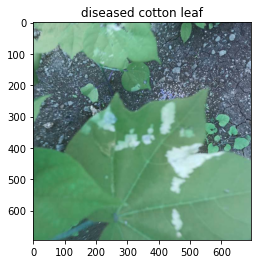

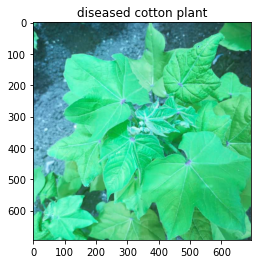

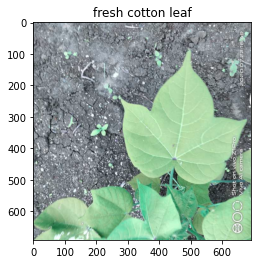

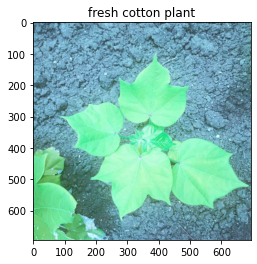

In [11]:
import os
import cv2
import matplotlib.pyplot as plt
categories = ["diseased cotton leaf","diseased cotton plant","fresh cotton leaf","fresh cotton plant"]

for category in categories:
    path = os.path.join(train,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_UNCHANGED)
        plt.title(category)
        plt.imshow(img_array)
        plt.show()
        break
    

In [12]:
print(img_array.shape)

(694, 694, 3)


(100, 100, 3)


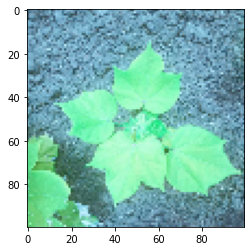

In [13]:
img_size = 100
new_array = cv2.resize(img_array,(img_size,img_size))
print(new_array.shape)
plt.imshow(new_array)
plt.show()

In [14]:
training = []
comp = [train,valid]
def create_train_data():
    for key in comp:
        path1 = os.path.join(key)
        for category in categories:
            path = os.path.join(path1,category)
            class_num = categories.index(category)
            for img in os.listdir(path):
                try:
                    img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_UNCHANGED)
                    new_array = cv2.resize(img_array,(img_size,img_size))
                    new_array = new_array/255
                    training.append([new_array,class_num])
                except Exception as e:
                    pass

create_train_data()

    

In [15]:
print(len(training))

2275


In [16]:
import random
random.shuffle(training)
for sample in training[:10]:
    print(sample[1]) 


3
3
2
1
2
2
1
1
2
1


In [17]:
X = []
y = []

for feature,label in training:
    X.append(feature)
    y.append(label)

X = np.array(X).reshape(-1,img_size,img_size,3)
y = np.array(y)

In [18]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()


In [19]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

In [20]:
y = pd.get_dummies(y)
y.head()

,0,1,2,3
0,0,0,0,1
1,0,0,0,1
2,0,0,1,0
3,0,1,0,0
4,0,0,1,0


In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0

In [26]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
X.shape

(2275, 100, 100, 3)

In [28]:
history = model.fit(X,y ,batch_size = 32, epochs=50,validation_split = 0.1, verbose = 1)



Epoch 1/50
64/64 [==============================] - 1s 14ms/step - loss: 0.1121 - accuracy: 0.9658 - val_loss: 0.1791 - val_accuracy: 0.9386
Epoch 2/50
64/64 [==============================] - 1s 11ms/step - loss: 0.1317 - accuracy: 0.9526 - val_loss: 0.1565 - val_accuracy: 0.9430
Epoch 3/50
64/64 [==============================] - 1s 18ms/step - loss: 0.0819 - accuracy: 0.9712 - val_loss: 0.1108 - val_accuracy: 0.9561
Epoch 4/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0721 - accuracy: 0.9731 - val_loss: 0.1329 - val_accuracy: 0.9561
Epoch 5/50
64/64 [==============================] - 1s 11ms/step - loss: 0.1090 - accuracy: 0.9624 - val_loss: 0.3527 - val_accuracy: 0.8904
Epoch 6/50
64/64 [==============================] - 1s 12ms/step - loss: 0.1787 - accuracy: 0.9428 - val_loss: 0.1713 - val_accuracy: 0.9342
Epoch 7/50
64/64 [==============================] - 1s 11ms/step - loss: 0.1221 - accuracy: 0.9653 - val_loss: 0.1177 - val_accuracy: 0.9561
Epoch 8/50
64

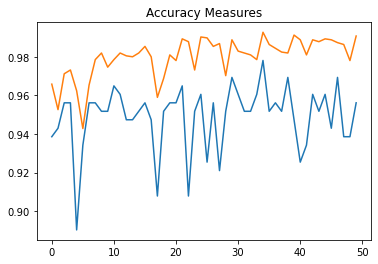

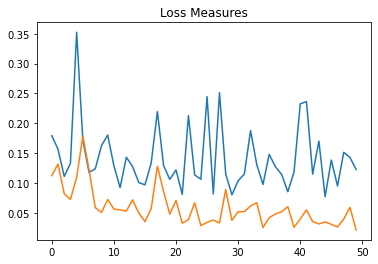

In [30]:
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["accuracy"])
plt.title("Accuracy Measures")
plt.show()


plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.title("Loss Measures")
plt.show()

**TESTING**

In [31]:
for category in categories:
    path = os.path.join(valid,category)
    for image in os.listdir(path):
        image_array = cv2.imread(os.path.join(path,image),cv2.IMREAD_UNCHANGED)
        new_arr = cv2.resize(image_array, (img_size,img_size))
        new_arr = new_arr/255
        pred = model.predict(new_arr.reshape(1,100,100,3))
        print(pred)
        break
    break    
        

[[1.0000000e+00 6.9431959e-17 1.1467112e-15 2.0804878e-20]]


In [32]:
pred_index = np.argmax(pred)
print(categories[pred_index])

diseased cotton leaf


In [33]:
path = os.path.join(valid,categories[2]) 
for image in os.listdir(path):
        image_array = cv2.imread(os.path.join(path,image),cv2.IMREAD_UNCHANGED)
        new_arr = cv2.resize(image_array, (img_size,img_size))
        new_arr = new_arr/255
        preds1 = model.predict(new_arr.reshape(1,100,100,3))
        print(preds1)
        break

[[6.4724905e-12 4.7587820e-19 1.0000000e+00 3.6628865e-16]]


In [34]:
pred_index = np.argmax(preds1)
print(categories[pred_index])

fresh cotton leaf


In [35]:
model.save("model.h5")
print("Saved model to disk")

Saved model to disk
